In [37]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import math
from scipy import stats

from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score, precision_recall_curve, matthews_corrcoef

from utils import *

In [28]:
# Find the best threshold for classification by the Youden’s J statistic.
def find_thr(labels, preds):
    fpr, tpr, thresholds = roc_curve(labels, preds)
    best_thr = thresholds[np.argmax(tpr - fpr)]
    return best_thr


# Function to calculate the test results (mean + std)
def getBinaryResults(dataset, drug, model):
    with open(f'../Results/single_binary_classification/{dataset}/{drug}_{model}.pkl', 'rb') as f:
        res = pickle.load(f)
    if 'lr' in model:
        with open(f'../Results/multi_binary_classification/{drug}_{model}.pkl', 'rb') as f:
            res = pickle.load(f)
    if "bert" in model or 'nn' in model or 'rf' in model or 'lr' in model:
        res_list, best_param_list = res
        res = res_list
    
    sen_list, spe_list, f1_list, mcc_list, auroc_list, auprc_list = [], [], [], [], [], []
    res_dict = {}
    for i in range(len(res)):
        if "bert" in model or 'nn' in model or 'rf' in model or 'lr' in model:
            train_logits, val_logits, test_logits, y_train, y_val, y_test = res[i]
        else:
            test_logits, y_test = res[i]
        best_thr = find_thr(y_test, test_logits)
        y_pred = [1 if x >= best_thr else 0 for x in test_logits]
        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
        sen = tp / (tp + fn)
        spe = tn / (tn + fp)
        f1 = 2 * tp / (2 * tp + fp + fn)
        mcc = matthews_corrcoef(y_test, y_pred)
        auroc = roc_auc_score(y_test, test_logits)
        precision, recall, _ = precision_recall_curve(y_test, test_logits)
        auprc = auc(recall, precision)

        sen_list.append(sen)
        spe_list.append(spe)
        f1_list.append(f1)
        mcc_list.append(mcc)
        auroc_list.append(auroc)
        auprc_list.append(auprc)

    res_dict['sen'] = (np.mean(sen_list), np.std(sen_list))
    res_dict['spe'] = (np.mean(spe_list), np.std(spe_list))
    res_dict['f1'] = (np.mean(f1_list), np.std(f1_list))
    res_dict['mcc'] = (np.mean(mcc_list), np.std(mcc_list))
    res_dict['auroc'] = (np.mean(auroc_list), np.std(auroc_list))
    res_dict['auprc'] = (np.mean(auprc_list), np.std(auprc_list))
    res_dict['num_exps'] = len(res)
    res_dict['sen_list'] = sen_list
    res_dict['spe_list'] = spe_list
    res_dict['f1_list'] = f1_list
    res_dict['mcc_list'] = mcc_list
    res_dict['auroc_list'] = auroc_list
    res_dict['auprc_list'] = auprc_list

    return res_dict

In [51]:
# plot the auroc for all drugs in the Walker dataset
def binaryBarPlot(dataset, matrix, model_list, model_name):
    drug_list = getDrugList(dataset)
    # model_list = ['nn','DeepAMR','WDNN', 'CNNGWP', 'bert1', 'bert1_no_freeze']
    # model_name = {'nn': 'NN', 'bert1': 'HGE-BERT', 'bert1_no_freeze': 'HGE-BERT (unfrozen)', 'DeepAMR': 'DeepAMR', 'WDNN': 'WDNN', 'CNNGWP': 'CNNGWP', 'rf': 'RF', 'LR': 'LR'}
    matrix_name = {'sen': 'Sensitivity', 'spe': 'Specificity', 'f1': 'F1-score', 'auroc': 'AUROC', 'mcc': 'MCC', 'auprc': 'AUPRC'}
    # group bar plot
    X_axis = np.arange(len(drug_list))
    res_dict = {}
    y_min = 1
    for model in model_list:
        res_dict[model] = {'mean': [], 'std': []}
        for drug in drug_list:
            mean_value, std_value = getBinaryResults(dataset, drug, model)[matrix]
            res_dict[model]['mean'].append(mean_value)
            res_dict[model]['std'].append(std_value)
            if mean_value < y_min:
                y_min = mean_value
    # let y_min be the smallest 0.1 multiple
    y_min = int(y_min * 10) / 10

    width = 0.15
    fig, ax = plt.subplots(figsize=(15, 5))
    for i, model in enumerate(model_list):
        ax.bar(X_axis + i * width, res_dict[model]['mean'], width, label=model_name[model])
    # plot the std as error bar with lowlims=True, don't show the arrow
    for i, model in enumerate(model_list):
        _, caplines, _ = ax.errorbar(X_axis + i * width, res_dict[model]['mean'], yerr=res_dict[model]['std'], fmt='none', ecolor='dimgray', capsize=2, capthick=1, elinewidth=2, lolims=True)
        caplines[0].set_marker('_')
    
    ax.set_ylim(ymin=y_min)
    ax.set_xlabel('Drug')
    ax.set_ylabel(matrix_name[matrix])
    ax.set_xticks(X_axis + width)
    ax.set_xticklabels([drug for drug in drug_list])
    ax.legend()
    # plt.savefig(f'../Figures/res_{dataset}_binary_{matrix}.png', bbox_inches='tight')
    plt.show()

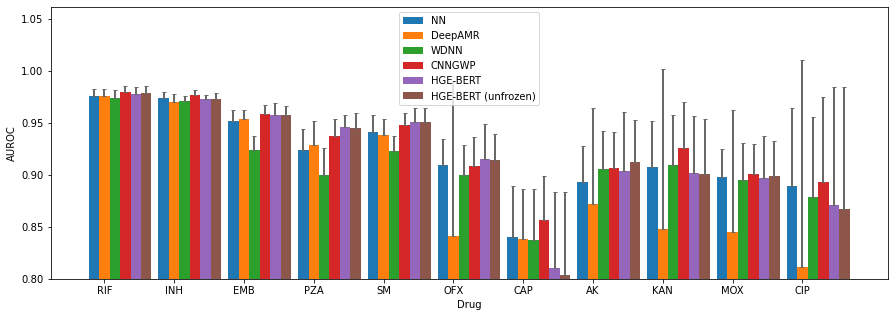

In [53]:
model_list = ['nn','DeepAMR','WDNN', 'CNNGWP', 'bert1', 'bert1_no_freeze']
model_name = {'nn': 'NN', 'bert1': 'HGE-BERT', 'bert1_no_freeze': 'HGE-BERT (unfrozen)', 'DeepAMR': 'DeepAMR', 'WDNN': 'WDNN', 'CNNGWP': 'CNNGWP', 'rf': 'RF', 'LR': 'LR'}
binaryBarPlot('Walker', 'auroc', model_list, model_name)

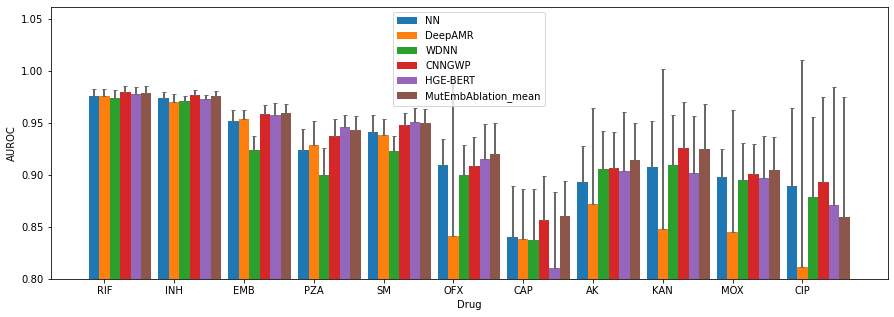

In [54]:
model_list = ['nn','DeepAMR','WDNN', 'CNNGWP', 'bert1', 'MutEmbAblation_mean']
model_name = {'nn': 'NN', 'bert1': 'HGE-BERT', 'bert1_no_freeze': 'HGE-BERT (unfrozen)', 'DeepAMR': 'DeepAMR', 'WDNN': 'WDNN', 'CNNGWP': 'CNNGWP', 'rf': 'RF', 'LR': 'LR', 'MutEmbAblation_mean': 'MutEmbAblation_mean'}
binaryBarPlot('Walker', 'auroc', model_list, model_name)

In [55]:
# in terms of the auroc, calculate the p-value of the difference between the two models
def binaryPValue(dataset, drug, matrix, model1, model2):
    res1 = getBinaryResults(dataset, drug, model1)[matrix + '_list']
    res2 = getBinaryResults(dataset, drug, model2)[matrix + '_list']
    _, p_value = stats.ttest_rel(res1, res2)
    return p_value

# calculate the p-value of the difference between the bert1 and bert1_no_freeze models
# the matric is auroc
drug_list = getDrugList('Walker')
model_list = ['nn','DeepAMR','WDNN', 'CNNGWP', 'bert1', 'MutEmbAblation_mean']

p_value_dict = {}
for drug in drug_list:
    for model in model_list:
        p_value = binaryPValue('Walker', drug, 'auroc', 'MutEmbAblation_mean', model)
        p_value_dict[(drug, model)] = p_value

# print the p-value less than 0.05
for key in p_value_dict:
    if p_value_dict[key] < 0.05:
        print(key, p_value_dict[key])

('RIF', 'nn') 0.012324602579747873
('RIF', 'DeepAMR') 0.0077288102268345555
('RIF', 'WDNN') 0.00028255901508565906
('INH', 'DeepAMR') 0.0004870513332837785
('INH', 'WDNN') 4.010611459969186e-06
('INH', 'bert1') 0.01506164320046033
('EMB', 'nn') 5.225269192234557e-05
('EMB', 'DeepAMR') 0.006707149481929221
('EMB', 'WDNN') 1.6469041486802655e-11
('PZA', 'nn') 6.757000379687893e-05
('PZA', 'DeepAMR') 0.007031570460698449
('PZA', 'WDNN') 6.777601829246275e-08
('PZA', 'CNNGWP') 0.023226554981764687
('PZA', 'bert1') 0.035123800126980645
('SM', 'nn') 0.007228562994463389
('SM', 'DeepAMR') 0.0008974114958481974
('SM', 'WDNN') 4.544565471672367e-09
('OFX', 'DeepAMR') 0.028009084700076164
('OFX', 'WDNN') 0.007827105921593634
('OFX', 'CNNGWP') 0.021571876830546313
('CAP', 'nn') 0.04755391995758138
('CAP', 'DeepAMR') 0.02739470005354842
('CAP', 'WDNN') 0.04774435574791301
('CAP', 'bert1') 0.006801827994922884
('AK', 'nn') 0.00013604171428305097
('KAN', 'DeepAMR') 0.030758949440515604
('KAN', 'bert

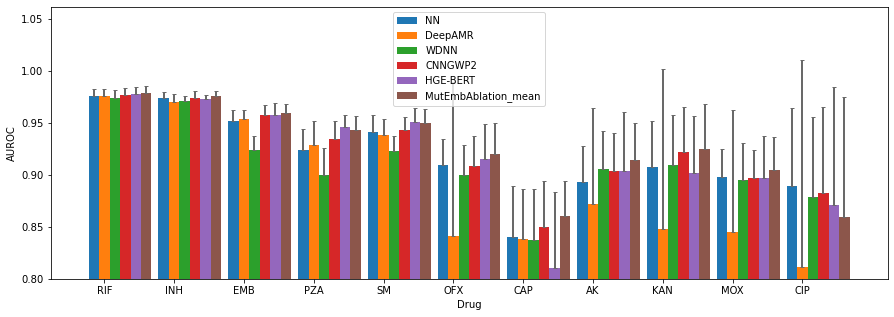

In [56]:
model_list = ['nn','DeepAMR','WDNN', 'CNNGWP2', 'bert1', 'MutEmbAblation_mean']
model_name = {'nn': 'NN', 'bert1': 'HGE-BERT', 'bert1_no_freeze': 'HGE-BERT (unfrozen)', 'DeepAMR': 'DeepAMR', 'WDNN': 'WDNN', 'CNNGWP2': 'CNNGWP2', 'rf': 'RF', 'LR': 'LR', 'MutEmbAblation_mean': 'MutEmbAblation_mean'}
binaryBarPlot('Walker', 'auroc', model_list, model_name)

In [57]:
# in terms of the auroc, calculate the p-value of the difference between the two models
def binaryPValue(dataset, drug, matrix, model1, model2):
    res1 = getBinaryResults(dataset, drug, model1)[matrix + '_list']
    res2 = getBinaryResults(dataset, drug, model2)[matrix + '_list']
    _, p_value = stats.ttest_rel(res1, res2)
    return p_value

# calculate the p-value of the difference between the bert1 and bert1_no_freeze models
# the matric is auroc
drug_list = getDrugList('Walker')
model_list = ['nn','DeepAMR','WDNN', 'CNNGWP2', 'bert1', 'MutEmbAblation_mean']

p_value_dict = {}
for drug in drug_list:
    for model in model_list:
        p_value = binaryPValue('Walker', drug, 'auroc', 'MutEmbAblation_mean', model)
        p_value_dict[(drug, model)] = p_value

# print the p-value less than 0.05
for key in p_value_dict:
    if p_value_dict[key] < 0.05:
        print(key, p_value_dict[key])

('RIF', 'nn') 0.012324602579747873
('RIF', 'DeepAMR') 0.0077288102268345555
('RIF', 'WDNN') 0.00028255901508565906
('RIF', 'CNNGWP2') 0.00714066769792479
('INH', 'DeepAMR') 0.0004870513332837785
('INH', 'WDNN') 4.010611459969186e-06
('INH', 'bert1') 0.01506164320046033
('EMB', 'nn') 5.225269192234557e-05
('EMB', 'DeepAMR') 0.006707149481929221
('EMB', 'WDNN') 1.6469041486802655e-11
('PZA', 'nn') 6.757000379687893e-05
('PZA', 'DeepAMR') 0.007031570460698449
('PZA', 'WDNN') 6.777601829246275e-08
('PZA', 'CNNGWP2') 0.005998072504602968
('PZA', 'bert1') 0.035123800126980645
('SM', 'nn') 0.007228562994463389
('SM', 'DeepAMR') 0.0008974114958481974
('SM', 'WDNN') 4.544565471672367e-09
('SM', 'CNNGWP2') 0.025558291102287273
('OFX', 'DeepAMR') 0.028009084700076164
('OFX', 'WDNN') 0.007827105921593634
('OFX', 'CNNGWP2') 0.043480691935408405
('CAP', 'nn') 0.04755391995758138
('CAP', 'DeepAMR') 0.02739470005354842
('CAP', 'WDNN') 0.04774435574791301
('CAP', 'bert1') 0.006801827994922884
('AK', 'n

In [41]:
# in terms of the auroc, calculate the p-value of the difference between the two models
def binaryPValue(dataset, drug, matrix, model1, model2):
    res1 = getBinaryResults(dataset, drug, model1)[matrix + '_list']
    res2 = getBinaryResults(dataset, drug, model2)[matrix + '_list']
    _, p_value = stats.ttest_rel(res1, res2)
    return p_value

# calculate the p-value of the difference between the bert1 and bert1_no_freeze models
# the matric is auroc
drug_list = getDrugList('Walker')
model_list = ['nn','DeepAMR','WDNN', 'CNNGWP', 'bert1', 'bert1_no_freeze']

p_value_dict = {}
for drug in drug_list:
    for model in model_list:
        p_value = binaryPValue('Walker', drug, 'auroc', 'bert1', model)
        p_value_dict[(drug, model)] = p_value

# print the p-value less than 0.05
for key in p_value_dict:
    if p_value_dict[key] < 0.05:
        print(key, p_value_dict[key])

('RIF', 'WDNN') 0.020476818216149755
('INH', 'CNNGWP') 0.008826279501785432
('EMB', 'nn') 0.020264187040476368
('EMB', 'WDNN') 1.371713458104809e-09
('PZA', 'nn') 1.101154032814537e-05
('PZA', 'DeepAMR') 0.0015469459123927257
('PZA', 'WDNN') 3.101306037268242e-08
('PZA', 'CNNGWP') 0.002243878154908218
('SM', 'nn') 0.014704953148555112
('SM', 'DeepAMR') 0.0011220161378383189
('SM', 'WDNN') 1.1804353782189343e-07
('OFX', 'DeepAMR') 0.03790106728486578
('OFX', 'WDNN') 0.03741854267221785
('CAP', 'CNNGWP') 0.014514221268263698
('KAN', 'CNNGWP') 0.007428217500997465


In [49]:
# plot the auroc for all drugs in the Walker dataset
def binaryBarPlotAblation(dataset, matrix):
    drug_list = getDrugList(dataset)
    # model_list = ['nn','MutEmbAblation_min', 'MutEmbAblation_mean', 'MutEmbAblation_max', 'bert1_no_pretrained', 'bert1', 'bert1_no_freeze']
    model_list = ['nn','MutEmbAblation_min', 'MutEmbAblation_mean', 'MutEmbAblation_max', 'bert1', 'bert1_no_freeze']
    matrix_name = {'sen': 'Sensitivity', 'spe': 'Specificity', 'f1': 'F1-score', 'auroc': 'AUROC', 'mcc': 'MCC', 'auprc': 'AUPRC'}
    # group bar plot
    X_axis = np.arange(len(drug_list))
    res_dict = {}
    y_min = 1
    for model in model_list:
        res_dict[model] = {'mean': [], 'std': []}
        for drug in drug_list:
            mean_value, std_value = getBinaryResults(dataset, drug, model)[matrix]
            res_dict[model]['mean'].append(mean_value)
            res_dict[model]['std'].append(std_value)
            if mean_value < y_min:
                y_min = mean_value
    # let y_min be the smallest 0.1 multiple
    y_min = int(y_min * 10) / 10

    width = 0.15
    fig, ax = plt.subplots(figsize=(15, 5))
    for i, model in enumerate(model_list):
        ax.bar(X_axis + i * width, res_dict[model]['mean'], width, label=model)
    # plot the std as error bar with lowlims=True, don't show the arrow
    for i, model in enumerate(model_list):
        _, caplines, _ = ax.errorbar(X_axis + i * width, res_dict[model]['mean'], yerr=res_dict[model]['std'], fmt='none', ecolor='dimgray', capsize=2, capthick=1, elinewidth=2, lolims=True)
        caplines[0].set_marker('_')
    
    ax.set_ylim(ymin=y_min)
    ax.set_xlabel('Drug')
    ax.set_ylabel(matrix_name[matrix])
    ax.set_xticks(X_axis + width)
    ax.set_xticklabels([drug for drug in drug_list])
    ax.legend()
    # plt.savefig(f'../Figures/res_{dataset}_binary_{matrix}.png', bbox_inches='tight')
    plt.show()

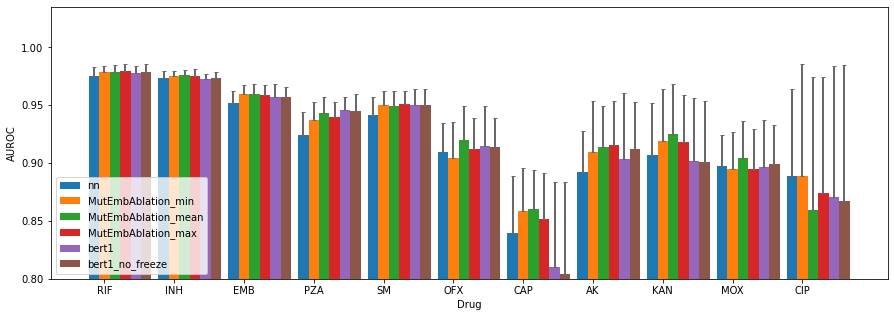

In [50]:
binaryBarPlotAblation('Walker', 'auroc')

In [46]:
# calculate the p-value of the difference between the bert1 and bert1_no_freeze models
# the matric is auroc
drug_list = getDrugList('Walker')
model_list = ['MutEmbAblation_min', 'MutEmbAblation_mean', 'MutEmbAblation_max', 'bert1_no_pretrained', 'bert1', 'bert1_no_freeze']

p_value_dict = {}
for drug in drug_list:
    for model in model_list:
        p_value = binaryPValue('Walker', drug, 'auroc', 'bert1', model)
        p_value_dict[(drug, model)] = p_value

# print the p-value less than 0.05
for key in p_value_dict:
    if p_value_dict[key] < 0.05:
        print(key, p_value_dict[key])

('RIF', 'MutEmbAblation_max') 0.012847372364343263
('INH', 'MutEmbAblation_min') 0.02328783422541396
('INH', 'MutEmbAblation_mean') 0.01506164320046033
('INH', 'MutEmbAblation_max') 0.03983916291924077
('EMB', 'bert1_no_pretrained') 0.02655868609810489
('PZA', 'MutEmbAblation_min') 0.00039047888752426945
('PZA', 'MutEmbAblation_mean') 0.035123800126980645
('PZA', 'MutEmbAblation_max') 0.000857793413580863
('PZA', 'bert1_no_pretrained') 0.0016601910552776417
('SM', 'bert1_no_pretrained') 0.03938431517425063
('OFX', 'MutEmbAblation_min') 0.03348907705133447
('CAP', 'MutEmbAblation_min') 0.010459941209706747
('CAP', 'MutEmbAblation_mean') 0.006801827994922884
('CAP', 'MutEmbAblation_max') 0.021060997084318887
('KAN', 'MutEmbAblation_min') 0.034478482307686124
('KAN', 'MutEmbAblation_mean') 0.01640840338905696


In [2]:
import numpy as np
import scipy.stats as stats

# Example data
list1 = [1.2, 2.4, 2.8, 3.1, 4.5, 5.0, 5.6, 6.2, 6.8, 7.5]
list2 = [1.1, 2.5, 2.7, 3.0, 4.6, 5.1, 5.5, 6.3, 6.7, 7.4]

_, p_value = stats.ttest_rel(list1, list2)
print(p_value)

0.5554454421055856


In [3]:
from scipy.special import stdtr
import math

# Step 1: Calculate differences
differences = [x - y for x, y in zip(list1, list2)]

# Step 2: Compute the mean and standard deviation of the differences
mean_diff = np.mean(differences)
std_diff = np.std(differences, ddof=1)

# Step 3: Calculate the t-statistic
n = len(differences)
t_stat = mean_diff / (std_diff / math.sqrt(n))

# Step 4: Compute the degrees of freedom
df = n - 1

# Step 5: Calculate the p-value using the t-distribution
p_value = 2 * stdtr(df, -abs(t_stat))

# Print the results
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

T-statistic: 0.6123724356957946
P-value: 0.5554454421055856
